In [1]:
from RandomForest import spark, process_dataframe, importance_bar_plot,sc
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

23/05/18 02:45:43 WARN Utils: Your hostname, Essams-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.14 instead (on interface en0)
23/05/18 02:45:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/18 02:45:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Training

In [2]:
df = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv("../../DataFiles/airline-train.csv")

df, string_indexers, bucketizers = process_dataframe(df)

In [3]:
LABEL_COL = "satisfaction_index"
FEATURES_COL = list(set(df.columns) - set([LABEL_COL]))
print("Label used: ", LABEL_COL)
print("Features used: ", FEATURES_COL)

Label used:  satisfaction_index
Features used:  ['Food and drink', 'Flight Distance_bucket', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Inflight service', 'Baggage handling', 'Inflight entertainment', 'Customer Type_index', 'Cleanliness', 'Type of Travel_index', 'Class_index', 'Leg room service', 'On-board service', 'Gender_index', 'Arrival Delay in Minutes_bucket', 'Checkin service', 'Age_bucket', 'Departure Delay in Minutes_bucket', 'Inflight wifi service', 'Online boarding', 'Gate location', 'Seat comfort']


In [4]:
assembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df = assembler.transform(df)

In [37]:
rf = RandomForestClassifier(labelCol=LABEL_COL, featuresCol="features", numTrees=50, maxDepth=15, featureSubsetStrategy="log2", seed=42)
model = rf.fit(df)
# Training accuracy
accuracy = model.transform(df).select("satisfaction_index", "prediction").rdd.map(lambda x: 1.0 if x[0] == x[1] else 0.0).mean()
print("Training Accuracy: ", accuracy)

Training Accuracy:  0.9744097148483507


## Validation

In [38]:
df_val = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv("../../DataFiles/airline-val.csv")

df_val, _, _ = process_dataframe(df_val, string_indexers, bucketizers)
assembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_val = assembler.transform(df_val)

In [39]:
# Validation accuracy
accuracy = model.transform(df_val).select("satisfaction_index", "prediction").rdd.map(lambda x: 1.0 if x[0] == x[1] else 0.0).mean()
print("Validation Accuracy: ", accuracy)

Validation Accuracy:  0.9600278067431296


## Feature Importance

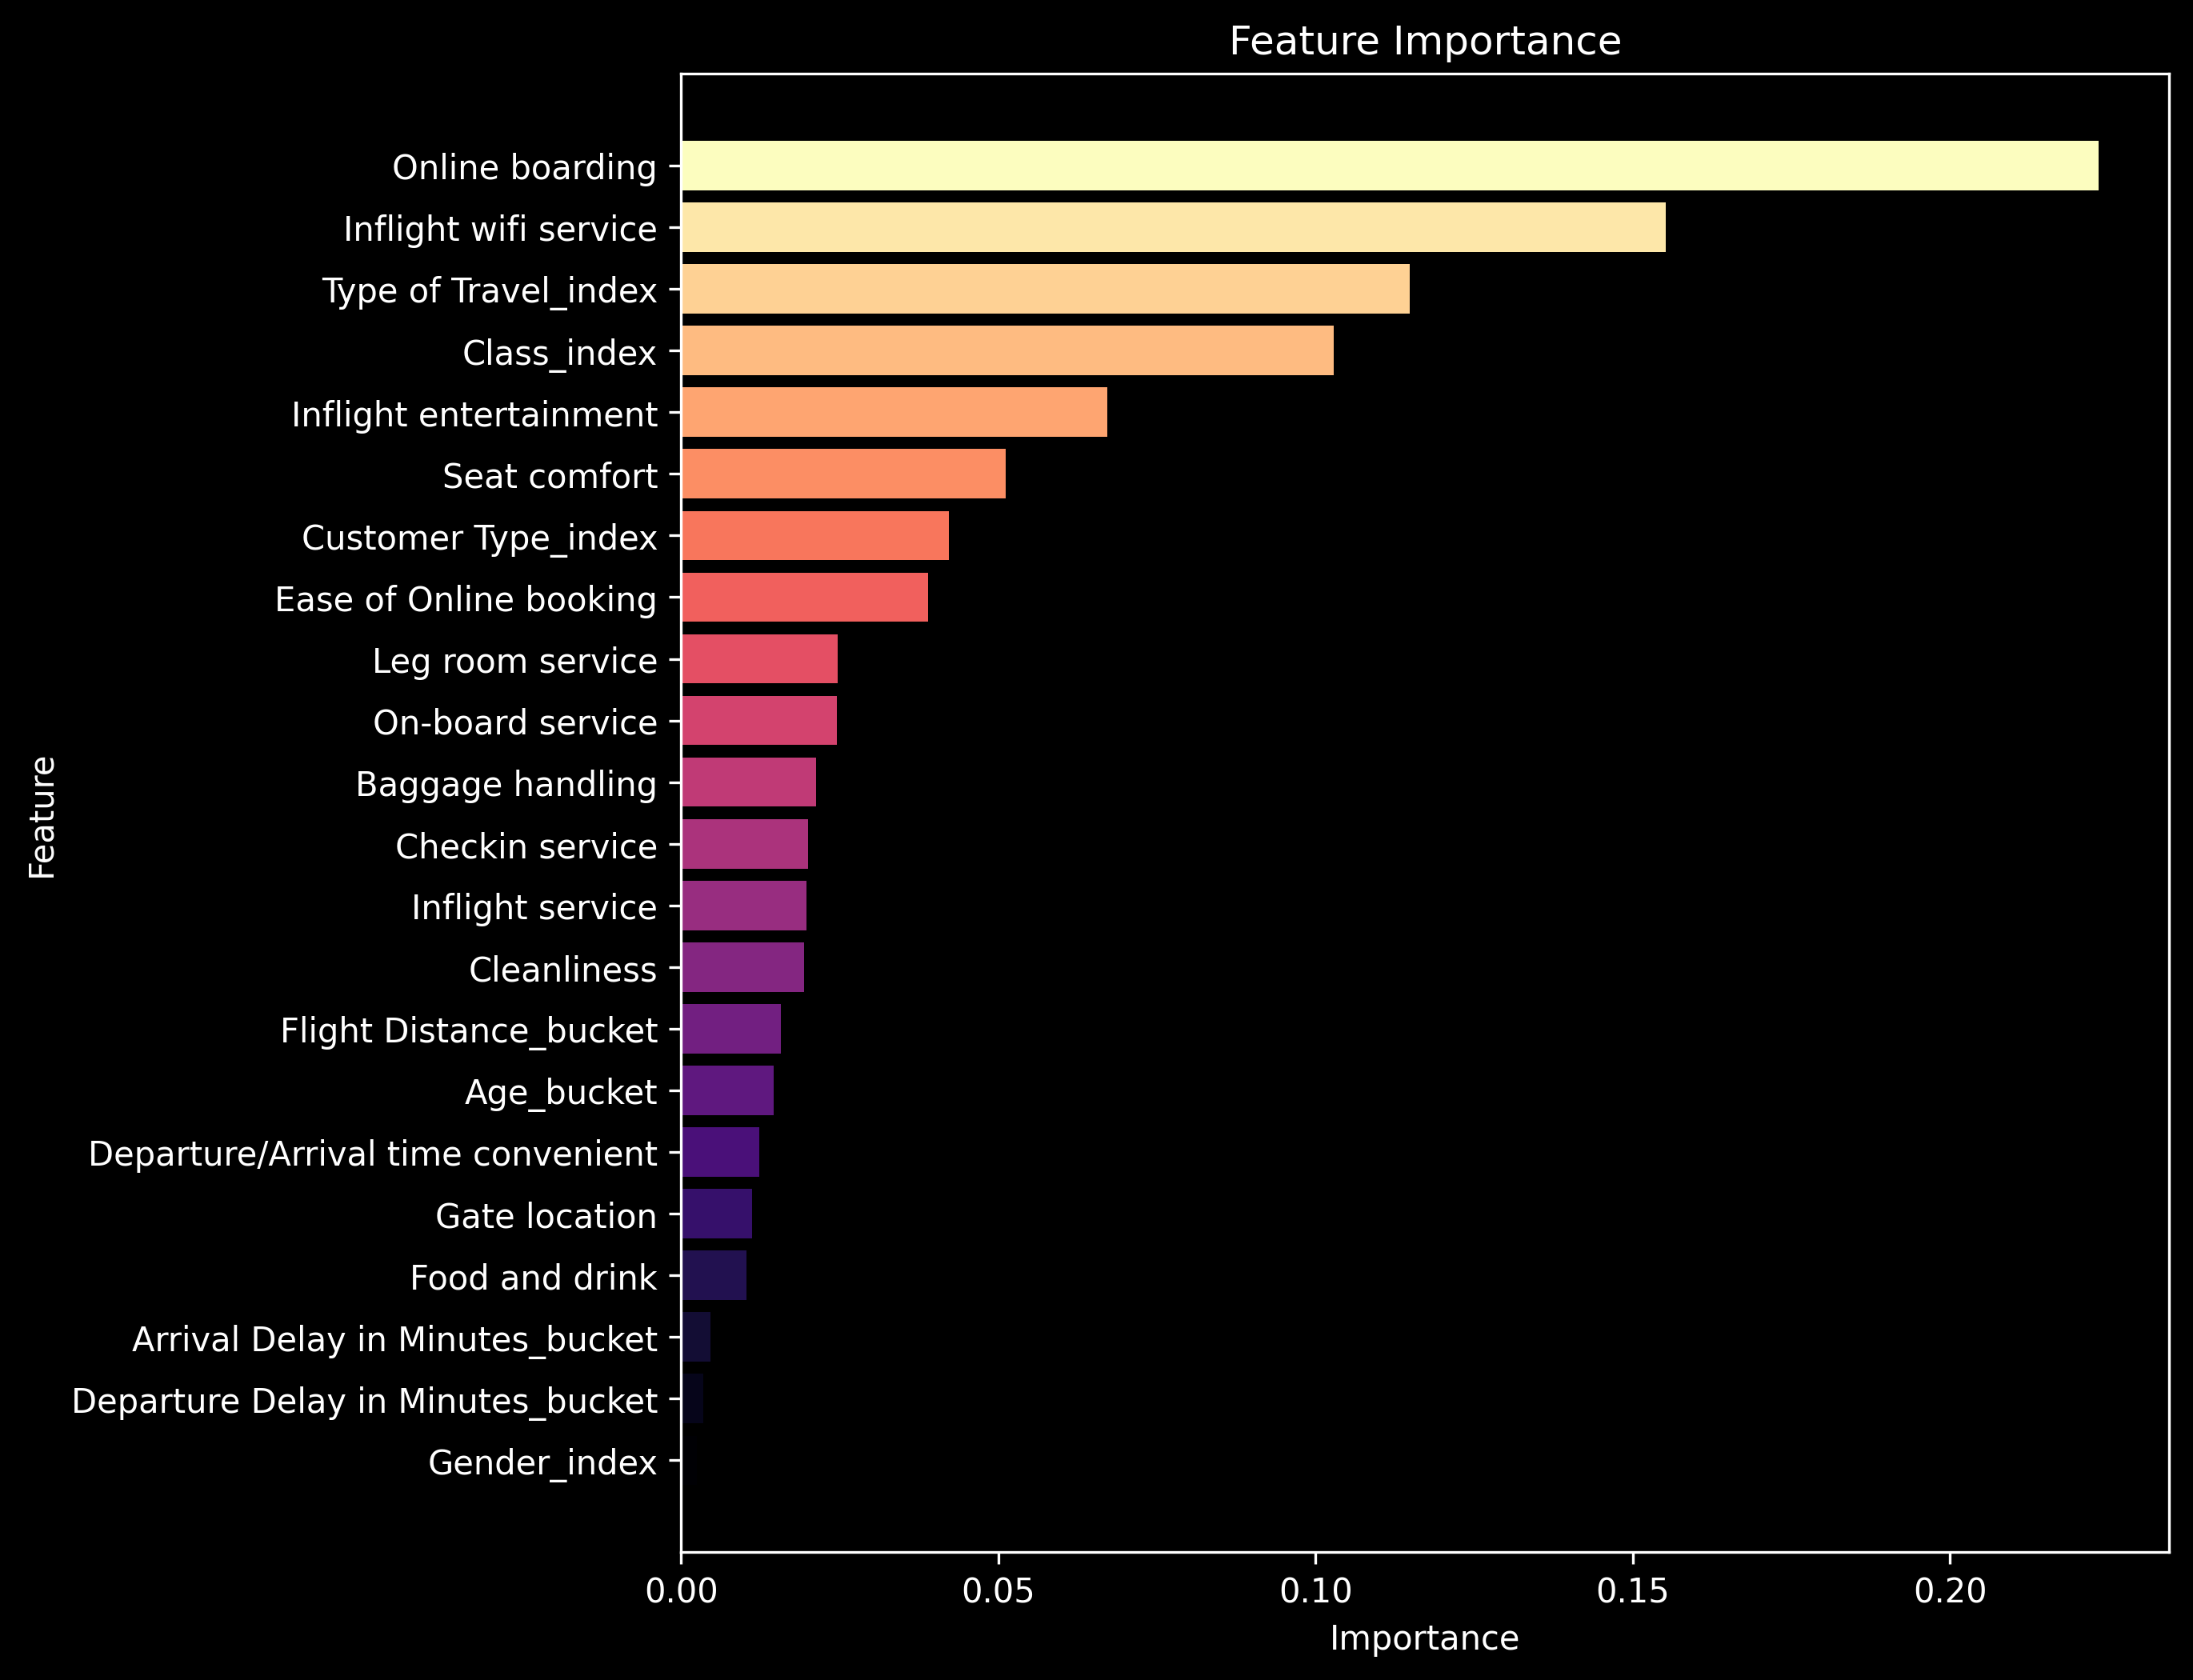

In [40]:
importance_bar_plot(model, FEATURES_COL)